# Week 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from week_3_functions import *
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
# %load_ext autoreload
# %autoreload 2

%reload_ext autoreload
%autoreload 2

## Churn prediction model

In [3]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

churn_data = fetch_data(url)

In [4]:
churn_data.head(1).T

,0
customerID,7590-VHVEG
gender,Female
SeniorCitizen,0
Partner,Yes
Dependents,No
tenure,1
PhoneService,No
MultipleLines,No phone service
InternetService,DSL
OnlineSecurity,No


In [5]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# data cleaning

df = data_cleaning_pipeline(churn_data)
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [8]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train.isnull().sum()


customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

This cell calculates the 'churn rate', which is the proportion of users that churn.

In [9]:
df_full_train.churn.value_counts(normalize=True)
global_churn_rate = df_full_train.churn.mean()

In [10]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies',
       'contract', 'paperlessbilling', 'paymentmethod']

In [11]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

In [12]:
cols = ['contract', 'gender', 'partner']
mi_scores = calculate_mutual_info(df_full_train, "churn", categorical)
mi_scores

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

In [13]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [14]:
df_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')

In [15]:
x_train, t_vec_enc = one_hot_encoding(df_train, categorical + numerical)
x_val, v_vec_enc = one_hot_encoding(df_val, categorical + numerical)


In [16]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [17]:
model.intercept_[0]

-0.10903415647215717

In [18]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.07 , -0.059,  0.141,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [19]:
v_vec_enc.get_feature_names_out()
dict(zip(v_vec_enc.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

In [20]:
y_pred = model.predict_proba(x_val)[:, 1]
churn_decision = y_pred >= 0.5

In [21]:
churn_decision.astype(int)
(y_val == churn_decision).mean()

0.8034066713981547

In [22]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred

,probability,prediction,actual,correct
0,0.008997,0,0,True
1,0.204523,0,0,True
2,0.212222,0,0,True
3,0.543047,1,1,True
4,0.213785,0,0,True
...,...,...,...,...
1404,0.313672,0,0,True
1405,0.039358,0,1,False
1406,0.136388,0,0,True
1407,0.799770,1,1,True


## Smaller model

In [23]:
small = ['contract', 'tenure', 'monthlycharges']

x_train_small, xt_small_enc = one_hot_encoding(df_train, small)
x_val_small, xv_small_enc = one_hot_encoding(df_val, small)

xt_small_enc.get_feature_names_out()


array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [24]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# training on full train dataset

In [25]:
y_full_train = df_full_train.churn.values

In [26]:
full_train_dataset, full_vec = one_hot_encoding(df_full_train, categorical + numerical)
test_dataset, test_vec = one_hot_encoding(df_test, categorical + numerical)
model = LogisticRegression().fit(X=full_train_dataset, y=y_full_train)

y_pred = model.predict_proba(test_dataset)[:, 1]

In [27]:
len(y_test), len(df_test), len(churn_decision)

(1409, 1409, 1409)

## Homework

In [28]:
def feat_eng(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new features from existing features in a dataframe.

    Args:
        df (pd.DataFrame): dataframe to create new features from

    Returns:
        pd.DataFrame: dataframe with new features
    """
    return (
        df.assign(
        rooms_per_household = lambda x: x.total_rooms / x.households,
        bedrooms_per_room = lambda x: x.total_bedrooms / x.total_rooms,
        population_per_household = lambda x: x.population / x.households,
        above_average = df['median_house_value'].apply(lambda x: 1 if x > df.median_house_value.mean() else 0)
        )
    )

def create_correlation_matrix(df: pd.DataFrame) -> None:

    # select only numeric columns
    df = df.select_dtypes(include=np.number)

    corr_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True)
    plt.show()




In [29]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

data = fetch_data(url)

# select ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity'] 
# from data
data = data[['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']]

data = feat_eng(data)
print(data.median_house_value.mean())
data.head(1)

X = data.drop('median_house_value', axis=1)
y = data['median_house_value']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



206855.81690891474


In [30]:
data.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

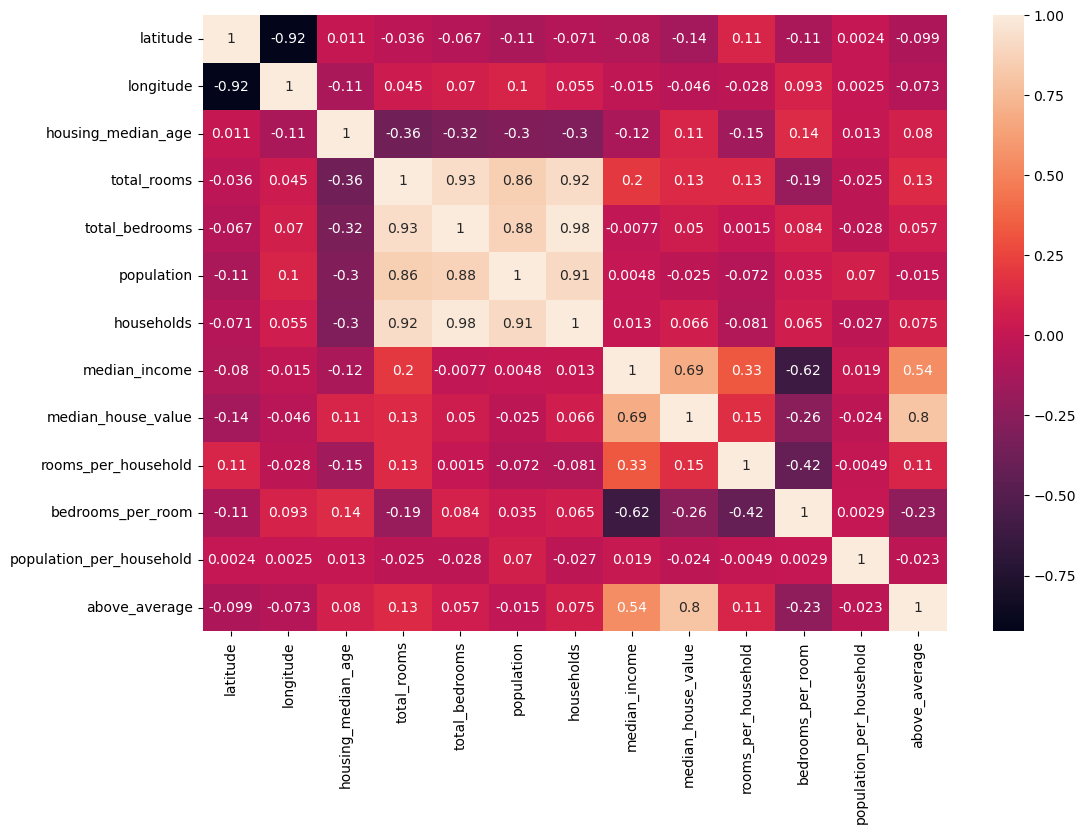

In [31]:
create_correlation_matrix(data)

In [8]:
import numpy as np
pred = np.array([0.2, 0.05, 0.1, 0.8, 0.6, 0.4])
response = np.array([0.221, 0.057, 0.199, 0.73, 0.599, 0.383])

# for i in pred:
#     for j in response:
#         top = np.sum((i - pred.mean()) * (j - response.mean()))
#         bottom = np.sum((i - pred.mean()) ** 2)
#         print(top.sum() / bottom.sum())

def calculate_beta1(x, y):
    n = len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n

    numerator = sum((x[i] - mean_x) * (y[i] - mean_y) for i in range(n))
    denominator = sum((x[i] - mean_x) ** 2 for i in range(n))

    beta1 = numerator / denominator
    return beta1

calculate_beta1(pred, response)



0.8576625824693684